<a href="https://colab.research.google.com/github/deepakri201/MIDRC_colab/blob/main/MIDRC_df_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameterization

In [1]:
!gcloud config set project  bwh-midrc-rapid-res-1655321320

Updated property [core/project].


In [2]:
from google.colab import auth
auth.authenticate_user()

In [28]:
# project_name = "bwh-midrc-rapid-res-1655321320"
# bucket_name = "midrc-analysis-bwh"
# bucket_path = "bpr-results"
# table_name = "radiomics_features"

project_name = "bwh-midrc-rapid-res-1655321320"
# bucket_name = "midrc-analysis-bwh"
bucket_name = "midrc-analysis-bwh-dk"
# bucket_path = "bpr-results"
bucket_path = "bpr-results/"

dataset_table_id = "midrc_dicom_us" # This already exists 
table_view_id_name = "ct_limited_open_a1_r1_dk"
# table_id = "bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk"

# Tables with ohif urls 
quantitative_measurements_features_table_with_ohif = 'quantitative_measurements_features_dk_with_ohif'
qualitative_measurements_regions_table_with_ohif = 'qualitative_measurements_regions_dk_with_ohif'
qualitative_measurements_landmarks_table_with_ohif = 'qualitative_measurements_landmarks_dk_with_ohif'

radiomics_table_name = "radiomics_features_dk"

seg_and_sr_table = "midrc_with_seg_sr_dk"

# Environment setup

In [4]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.colors import ListedColormap
import seaborn as sb 
import pandas as pd 
import numpy as np
from google.cloud import bigquery

# Queries

In [5]:
# %%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320

# WITH
#   nlst_instances_per_series AS (
#     SELECT
#       DISTINCT(StudyInstanceUID),
#       SeriesInstanceUID,
#       COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
#       COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
#       COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
#       MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
#       MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
#       MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
#       MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
#       STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer
#     FROM
#       bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
#     WHERE
#       (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
#     GROUP BY
#       StudyInstanceUID,
#       SeriesInstanceUID
#       ), 
#   nlst_values_per_series AS (
#     SELECT 
#     ANY_VALUE(dicom_all.PatientID) AS PatientID,
#     dicom_all.SeriesInstanceUID,
#     ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
#     ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
#     ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned
#   FROM
#     bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
#   JOIN
#     nlst_instances_per_series
#   ON
#     dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
#   WHERE
#     min_SliceThickness >= 1.5 
#     AND max_SliceThickness <= 3.5 
#     AND nlst_instances_per_series.num_instances > 100
#     AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
#     AND nlst_instances_per_series.orientation_count = 1
#     AND has_localizer = "false"
#   GROUP BY
#     SeriesInstanceUID
#   )
#   SELECT 
#     dicom_all.PatientID,
#     dicom_all.StudyInstanceUID,
#     dicom_all.SeriesInstanceUID,
#     dicom_all.SOPInstanceUID,
#     dicom_all.collection_id,
#     dicom_all.PatientAge,
#     dicom_all.PatientWeight,
#     dicom_all.PatientSex,
#     dicom_all.PixelSpacing,
#     nlst_values_per_series.num_instances,
#     nlst_values_per_series.SliceThickness,
#     nlst_values_per_series.PatientHeightScanned
#   FROM
#     bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
#   JOIN
#     nlst_values_per_series 
#   ON
#     dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID

In [6]:
# %%bigquery ct_limited_open_a1_r1 --project=bwh-midrc-rapid-res-1655321320 

query = """
WITH
  nlst_instances_per_series AS (
    SELECT
      # DISTINCT(StudyInstanceUID),
      StudyInstanceUID,
      SeriesInstanceUID,
      COUNT(DISTINCT(SOPInstanceUID)) AS num_instances,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImagePositionPatient,"/"))) AS position_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(PixelSpacing,"/"))) AS pixel_spacing_count,
      COUNT(DISTINCT(ARRAY_TO_STRING(ImageOrientationPatient,"/"))) AS orientation_count,
      MIN(SAFE_CAST(SliceThickness AS float64)) AS min_SliceThickness,
      MAX(SAFE_CAST(SliceThickness AS float64)) AS max_SliceThickness,
      MIN(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as min_SliceLocation, 
      MAX(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS float64)) as max_SliceLocation,
      STRING_AGG(DISTINCT(SAFE_CAST("LOCALIZER" IN UNNEST(ImageType) AS string)),"") AS has_localizer,
      ANY_VALUE(dicom_all.ImageOrientationPatient) AS ImageOrientationPatient
    FROM
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all
    WHERE
      (collection_id = "Open-R1" or collection_id = "Open-A1") and Modality = "CT"
    GROUP BY
      StudyInstanceUID,
      SeriesInstanceUID
      ), 

    distinct_slice_location_difference_values AS (
  SELECT 
      # DISTINCT(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC) - LAG(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) OVER(partition by SeriesInstanceUID ORDER BY SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC) DESC)) AS SliceLocation_difference,
      DISTINCT(TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) - LAG(TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1),1) OVER(partition by SeriesInstanceUID ORDER BY TRUNC(SAFE_CAST(ImagePositionPatient[SAFE_OFFSET(2)] AS NUMERIC),1) DESC)) AS SliceLocation_difference,
      SeriesInstanceUID,
      StudyInstanceUID
  FROM
      # `bigquery-public-data.idc_current.dicom_all`
      bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all

  ),

  nlst_values_per_series AS (
  SELECT 
    # ANY_VALUE(dicom_all.PatientID) AS PatientID,
    # dicom_all.SeriesInstanceUID,
    distinct_slice_location_difference_values.SeriesInstanceUID AS SeriesInstanceUID, 
    ANY_VALUE(nlst_instances_per_series.num_instances) AS num_instances,
    ANY_VALUE(nlst_instances_per_series.max_SliceThickness) AS SliceThickness,
    ANY_VALUE((nlst_instances_per_series.max_SliceLocation - nlst_instances_per_series.min_SliceLocation)) AS PatientHeightScanned, 
    COUNT(distinct_slice_location_difference_values.SliceLocation_difference) as num_differences,
    MAX(ABS(distinct_slice_location_difference_values.SliceLocation_difference)) as max_difference,
    MIN(ABS(distinct_slice_location_difference_values.SliceLocation_difference)) as min_difference,
    ANY_VALUE(nlst_instances_per_series.ImageOrientationPatient) AS ImageOrientationPatient
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
    nlst_instances_per_series
  JOIN
    # nlst_instances_per_series
    distinct_slice_location_difference_values
  ON
    # dicom_all.SeriesInstanceUID = nlst_instances_per_series.SeriesInstanceUID
    nlst_instances_per_series.SeriesInstanceUID = distinct_slice_location_difference_values.SeriesInstanceUID 
  WHERE
    nlst_instances_per_series.min_SliceThickness >= 1.5
    AND nlst_instances_per_series.max_SliceThickness <= 3.5
    AND nlst_instances_per_series.num_instances > 100
    AND nlst_instances_per_series.num_instances/nlst_instances_per_series.position_count = 1
    AND nlst_instances_per_series.pixel_spacing_count = 1
    AND nlst_instances_per_series.orientation_count = 1
    AND has_localizer = "false" 
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(0)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(1)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(0)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(2)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(4)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(3)] AS float64))
    AND ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(4)] AS float64)) > ABS(SAFE_CAST(nlst_instances_per_series.ImageOrientationPatient[SAFE_OFFSET(5)] AS float64))
  GROUP BY
    distinct_slice_location_difference_values.SeriesInstanceUID

  )

  SELECT 
    dicom_all.PatientID,
    dicom_all.StudyInstanceUID,
    dicom_all.SeriesInstanceUID,
    dicom_all.SOPInstanceUID, 
    dicom_all.collection_id, 
    dicom_all.PatientAge,
    dicom_all.PatientWeight,
    nlst_values_per_series.num_instances,
    nlst_values_per_series.SliceThickness, 
    nlst_values_per_series.PatientHeightScanned,
    nlst_values_per_series.num_differences,
    nlst_values_per_series.max_difference, 
    nlst_values_per_series.min_difference
  FROM 
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all AS dicom_all
  JOIN 
    nlst_values_per_series
  ON 
    dicom_all.SeriesInstanceUID = nlst_values_per_series.SeriesInstanceUID 
  WHERE
    nlst_values_per_series.num_differences <= 2
    AND nlst_values_per_series.max_difference/nlst_values_per_series.min_difference < 2
"""

client = bigquery.Client(project=project_name)

table_id = '.'.join([project_name, dataset_table_id, table_view_id_name])
job_config = bigquery.QueryJobConfig(destination=table_id)

# Try to create table 
try: 
  print ('trying to create table: ' + str(table_id))
  query_job = client.query(query, job_config=job_config) 
  result = query_job.result()  
  print ('created table: ' + str(table_id))
# If table already exists, don't do anything
except: 
  print('table ' + str(table_id) + ' already exists')
  pass 



trying to create table: bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk
table bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk already exists


In [7]:
# Get the dataframe from the table 
# need to additionally get PatientSex and PixelSpacing. 

client = bigquery.Client(project=project_name)
table_id = '.'.join([project_name, dataset_table_id, table_view_id_name])
table_id_dicom_all = '.'.join([project_name, dataset_table_id, 'dicom_all'])
print(table_id)

query_view = f"""
  SELECT 
    midrc.PatientID, 
    midrc.StudyInstanceUID,
    midrc.SeriesInstanceUID,
    midrc.SOPInstanceUID,
    midrc.collection_id, 
    midrc.PatientAge, 
    midrc.PatientWeight, 
    dicom_all.PatientSex,
    midrc.num_instances,
    midrc.SliceThickness,
    midrc.PatientHeightScanned, 
    dicom_all.PixelSpacing
  FROM 
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk as midrc
    {table_id} as midrc 
  JOIN
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.dicom_all as dicom_all 
    {table_id_dicom_all} as dicom_all
  ON
    dicom_all.SOPInstanceUID = midrc.SOPInstanceUID ;
  
  """ 
job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config) 
ct_limited_open_a1_r1 = result.to_dataframe()


bwh-midrc-rapid-res-1655321320.midrc_dicom_us.ct_limited_open_a1_r1_dk


In [8]:
ct_limited_open_a1_r1

,PatientID,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,PatientSex,num_instances,SliceThickness,PatientHeightScanned,PixelSpacing
0,10000364-1547354,2.16.840.1.114274.1818.56662035327095526251208...,2.16.840.1.114274.1818.50319648238506336118806...,2.16.840.1.114274.1818.50548559286662855317606...,Open-A1,060Y,48.58,None,188,1.5,280.5,"[0.68359375, 0.68359375]"
1,10000364-778380,2.16.840.1.114274.1818.50296818259159386847243...,2.16.840.1.114274.1818.47259335701502687442069...,2.16.840.1.114274.1818.47605941828411344331564...,Open-A1,035Y,136.079,None,164,1.5,244.5,"[0.671875, 0.671875]"
2,10000364-1803288,2.16.840.1.114274.1818.57475519632632091451627...,2.16.840.1.114274.1818.46732187403536287861328...,2.16.840.1.114274.1818.57244040440384660791290...,Open-A1,071Y,95.0,None,116,2.5,287.5,"[0.703125, 0.703125]"
3,10000364-831472,2.16.840.1.114274.1818.54424860931233320348820...,2.16.840.1.114274.1818.49789565694187970551392...,2.16.840.1.114274.1818.49142379868273626391522...,Open-A1,065Y,101.0,None,125,2.5,310.0,"[0.748047, 0.748047]"
4,10000364-2397286,2.16.840.1.114274.1818.52516641044272817031204...,2.16.840.1.114274.1818.46866524953623188481003...,2.16.840.1.114274.1818.53568532134166757873612...,Open-A1,056Y,104.327,None,156,2.0,310.0,"[0.7265625, 0.7265625]"
...,...,...,...,...,...,...,...,...,...,...,...,...
75550,10000364-1584234,2.16.840.1.114274.1818.49651995567882524771604...,2.16.840.1.114274.1818.56755367596946500258834...,2.16.840.1.114274.1818.57614822155533902914396...,Open-A1,030Y,74.118,None,243,1.5,242.0,"[0.537109375, 0.537109375]"
75551,10000364-1841406,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,None,243,2.5,605.0,"[0.851562, 0.851562]"
75552,10000364-1841406,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,None,243,2.5,605.0,"[0.851562, 0.851562]"
75553,10000364-1841406,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,1.3.6.1.4.1.5962.99.1.3492129840.282517718.161...,Open-A1,None,None,None,243,2.5,605.0,"[0.851562, 0.851562]"


# Data plots

Need to only keep the SeriesInstanceUIDs that were fully processed (369). Get the list of IDS from the bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr_dk table 

In [39]:
client = bigquery.Client(project=project_name)
table_id = '.'.join([project_name, dataset_table_id, seg_and_sr_table])
print(table_id)

query_view = f"""
    SELECT ref.SeriesInstanceUID
    FROM {table_id} as midrc, 
    UNNEST(ReferencedSeriesSequence) as ref
    """

job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config) 
series_df = result.to_dataframe()
series_ids_keep = series_df['SeriesInstanceUID'].values

print(len(series_ids_keep))

bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr_dk
369


Now create ct_limited_open_a1_r1 columns with just the specific ids from series_ids_keep

In [41]:
# ct_limited_open_a1_r1 = ct_limited_open_a1_r1[ct_limited_open_a1_r1['SeriesInstanceUID']=series_ids_keep] 

ct_limited_open_a1_r1 = ct_limited_open_a1_r1.loc[ct_limited_open_a1_r1['SeriesInstanceUID'].isin(series_ids_keep)]

In [42]:
ct_limited_open_a1_r1.columns

Index(['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'collection_id', 'PatientAge', 'PatientWeight', 'PatientSex',
       'num_instances', 'SliceThickness', 'PatientHeightScanned',
       'PixelSpacing'],
      dtype='object')

In [43]:
ct_limited_open_a1_r1.describe()

,num_instances,SliceThickness,PatientHeightScanned
count,72772.000000,72772.000000,72772.000000
mean,259.797147,1.815087,362.086479
std,194.193815,0.437432,129.160134
min,101.000000,1.500000,178.500000
25%,153.000000,1.500000,282.500000
50%,199.000000,1.500000,310.500000
75%,233.000000,2.000000,418.600000
max,997.000000,3.000000,821.250000


In [44]:
ct_agg = ct_limited_open_a1_r1.groupby('SeriesInstanceUID').first()

In [45]:
ct_agg.columns

Index(['PatientID', 'StudyInstanceUID', 'SOPInstanceUID', 'collection_id',
       'PatientAge', 'PatientWeight', 'PatientSex', 'num_instances',
       'SliceThickness', 'PatientHeightScanned', 'PixelSpacing'],
      dtype='object')

In [46]:
ct_agg

,PatientID,StudyInstanceUID,SOPInstanceUID,collection_id,PatientAge,PatientWeight,PatientSex,num_instances,SliceThickness,PatientHeightScanned,PixelSpacing
SeriesInstanceUID,,,,,,,,,,,
1.2.826.0.1.3680043.10.474.419639.105799060738901793068313281334,419639-009729,1.2.826.0.1.3680043.10.474.419639.198074364500...,1.2.826.0.1.3680043.10.474.419639.216774623993...,Open-R1,070Y,None,F,178,2.5,442.5,"[0.894531, 0.894531]"
1.2.826.0.1.3680043.10.474.419639.106364025147079899289440200715,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.196197524579...,Open-R1,070Y,None,M,180,2.5,447.5,"[0.896484, 0.896484]"
1.2.826.0.1.3680043.10.474.419639.149051607502633615235577977952,419639-008615,1.2.826.0.1.3680043.10.474.419639.774626438417...,1.2.826.0.1.3680043.10.474.419639.252192565293...,Open-R1,070Y,None,M,145,2.5,360.0,"[0.703125, 0.703125]"
1.2.826.0.1.3680043.10.474.419639.189346812051260775638656981947,419639-006313,1.2.826.0.1.3680043.10.474.419639.162466515375...,1.2.826.0.1.3680043.10.474.419639.163437909538...,Open-R1,055Y,None,M,193,2.5,480.0,"[0.787109, 0.787109]"
1.2.826.0.1.3680043.10.474.419639.198735019931123383691750806063,419639-006462,1.2.826.0.1.3680043.10.474.419639.314532011473...,1.2.826.0.1.3680043.10.474.419639.328882090886...,Open-R1,045Y,None,F,184,2.5,457.5,"[0.664062, 0.664062]"
...,...,...,...,...,...,...,...,...,...,...,...
2.16.840.1.114274.1818.57428402673806292631213613164537153178,10000364-928517,2.16.840.1.114274.1818.55876617153397017048056...,2.16.840.1.114274.1818.56276646717508254016845...,Open-A1,061Y,120.203,None,149,2.0,296.0,"[0.830078125, 0.830078125]"
2.16.840.1.114274.1818.57457975148752254386654243559823579777,10000364-5793210,2.16.840.1.114274.1818.56731110153452733811482...,2.16.840.1.114274.1818.56557629203805092978173...,Open-A1,062Y,96.163,None,126,2.0,250.0,"[0.60546875, 0.60546875]"
2.16.840.1.114274.1818.575582461955879718414460096035779985847,10000364-1714989,2.16.840.1.114274.1818.49976856396551574068319...,2.16.840.1.114274.1818.46933136539329108494476...,Open-A1,056Y,74.39,None,165,1.5,246.0,"[0.61328125, 0.61328125]"


In [47]:
x  = ct_limited_open_a1_r1['PixelSpacing'].tolist()

In [48]:
x[0]

array(['0.68359375', '0.68359375'], dtype=object)

In [49]:
pxspace = [k[0] for k in ct_limited_open_a1_r1['PixelSpacing']]

In [50]:
pxspace[:5]

['0.68359375', '0.671875', '0.703125', '0.7265625', '0.646484375']

In [51]:
pxspace = [k[0] for k in ct_agg['PixelSpacing']]


In [52]:
pxspace[:5]

['0.894531', '0.896484', '0.703125', '0.787109', '0.664062']

In [53]:
ct_limited_open_a1_r1['num_instances']

0        188
1        164
2        116
4        156
5        186
        ... 
75550    243
75551    243
75552    243
75553    243
75554    243
Name: num_instances, Length: 72772, dtype: Int64

In [21]:
# ct_limited_open_a1_r1['pxspace']=pxspace
# ct_limited_open_a1_r1['pxspace'] =ct_limited_open_a1_r1['pxspace'].astype(float)

In [54]:
ct_agg['pxspace']=pxspace
ct_agg['pxspace'] =ct_agg['pxspace'].astype(float)

In [55]:
x1  = ct_limited_open_a1_r1['SliceThickness'].tolist()
#x1

[1.5, 2.0, 2.5, 3]
[178. 120.  48.  23.]
[48.23848238 32.5203252  13.00813008  6.23306233]


([<matplotlib.patches.Wedge at 0x7fec7e590fa0>,
 [Text(0.06084258908828916, 1.0983160653259305, '1.5'),
  Text(-0.6742717516141828, -0.8691131140278242, '2.0'),
  Text(0.7661426991288662, -0.7893195579557976, '2.5'),
  Text(1.078977832414188, -0.2140253189666592, '3.0')],
 [Text(0.03318686677543045, 0.5990814901777802, '48%'),
  Text(-0.36778459178955425, -0.47406169856063135, '33%'),
  Text(0.41789601770665424, -0.43053794070316226, '13%'),
  Text(0.5885333631350117, -0.11674108307272318, '6%')])

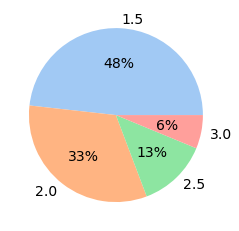

In [56]:
# v=ct_limited_open_a1_r1['SliceThickness'].tolist()
v = ct_agg['SliceThickness'].tolist()
vset = set(v)
v_manual = [1.5, 2., 2.5, 3]
eps = 0.1
counts = np.zeros(len(v_manual))
for k in v:
  for i in range(len(v_manual)):
    if abs(k-v_manual[i])<eps:
      counts[i]+=1
print(v_manual)
print(counts)
counts = counts/np.sum(counts)*100
print(counts)

#define Seaborn color palette to use
colors = sb.color_palette('pastel')

plt.pie( counts, labels = ['%.1f'%x for x in v_manual], colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})


In [57]:
# v1=ct_limited_open_a1_r1['PatientSex'].tolist()
v1 = ct_agg['PatientSex'].tolist()
vset = set(v1)
vset

{'F', 'M', None}

[337.  19.  13.]
[91.32791328  5.14905149  3.52303523]


([<matplotlib.patches.Wedge at 0x7fec7e20a3d0>,
 [Text(-1.0594284784151313, 0.295992059222878, 'None'),
  Text(1.0202528127662684, -0.411198489834919, 'F'),
  Text(1.0932694497101756, -0.12149860217471628, 'M')],
 [Text(-0.5778700791355261, 0.16145021412156982, '91%'),
  Text(0.5565015342361463, -0.22429008536450126, '5%'),
  Text(0.5963287907510049, -0.06627196482257251, '4%')])

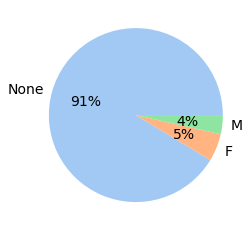

In [58]:
counts = np.zeros(len(vset))
vlist = list(vset)
for k in v1:
  counts[vlist.index(k)]+=1

print(counts)
counts = counts/np.sum(counts)*100
print(counts)

#define Seaborn color palette to use
colors = sb.color_palette('pastel')

# labels = ['F', 'M', 'None']
labels = vlist 
labels = [str(f) for f in labels]

plt.pie( counts, labels=labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})

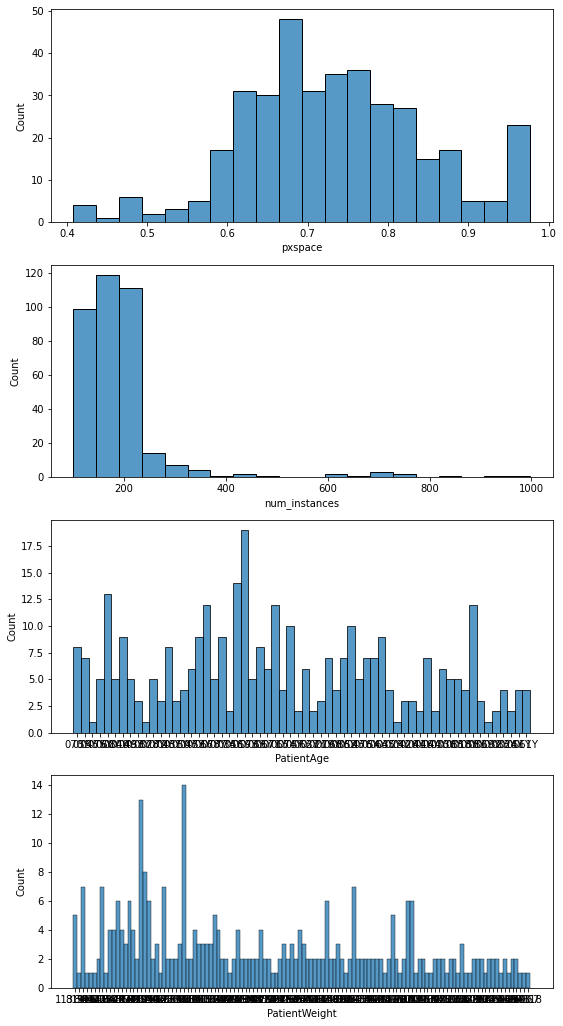

In [59]:
# plot selected

fig, ax = plt.subplots(4, 1, figsize=(9, 18))

x1 = np.random.randint(low=0, high=2, size=20)

# Slice Thickness 
#sb.histplot(ax=ax[0], x="SliceThickness", data=ct_limited_open_a1_r1)

# Slice Resolution 
sb.histplot(ax=ax[0], bins=20, x="pxspace", data=ct_agg)
#ax.set_xticks(np.arange(0, len(x1)+1, 25))

# Number of Slices
sb.histplot(ax=ax[1], bins=20, x="num_instances", data=ct_agg)
#plt.xlim(0,800)

# PatientAge
sb.histplot(ax=ax[2], x="PatientAge", bins = 20, data=ct_agg)
#ax.set_xticks(np.arange(0, len(x1)+1, 25))

# PatientWeight
sb.histplot(ax=ax[3], x="PatientWeight", bins = 20, data=ct_agg)

# BodyPartExamined
#sb.countplot(ax=ax[0], x="BodyPartExamined", data=ct_open_a1_r1)

# PatientSex
#sb.countplot(ax=ax[5], x="PatientSex", data=ct_limited_open_a1_r1)


# Radiomics plots - DK

Need to plot radiomics features separately for each feature across the two regions - left and right lung. 

Need to include clickable plot to display ohif url. 

In [60]:
# Get the dataframe from the table for a single feature

client = bigquery.Client(project=project_name)
table_id = '.'.join([project_name, dataset_table_id, quantitative_measurements_features_table_with_ohif])

query_view = f"""
  SELECT 
    * 
  FROM 
    {table_id}
  # WHERE
  #   Quantity.CodeMeaning = "Flatness"
  """ 
job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config) 
quantitative_measurements_features_df = result.to_dataframe()

In [61]:
quantitative_measurements_features_df

,PatientID,SOPInstanceUID,SeriesDescription,measurementGroup_number,segmentationInstanceUID,segmentationSegmentNumber,sourceSegmentedSeriesUID,trackingIdentifier,Quantity,Value,Units,finding,findingSite,viewer_url
0,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 1', 'CodeValue': ...",0.022000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
1,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 2', 'CodeValue': ...",0.166000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
2,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Sphericity', 'CodeValue': 'QC...",0.550000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
3,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Spherical Disproportion', 'Co...",1.818000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
4,419639-009729,1.2.276.0.7230010.3.1.4.481037312.8709.1674257...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.7172.1674164...,[1],1.2.826.0.1.3680043.10.474.419639.105799060738...,Measurements group 1 - Right,"{'CodeMeaning': 'Sphericity', 'CodeValue': 'QC...",0.495000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,10000364-6553682,1.2.276.0.7230010.3.1.4.481037312.53280.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.281134.16741...,[2],2.16.840.1.114274.1818.57397787504841581752943...,Measurements group 2 - Left,"{'CodeMeaning': 'Surface Area of Mesh', 'CodeV...",89594.747000000,"{'CodeMeaning': 'square millimeter', 'CodeValu...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
10328,10000364-5793210,1.2.276.0.7230010.3.1.4.481037312.56910.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.282551.16741...,[2],2.16.840.1.114274.1818.57457975148752254386654...,Measurements group 2 - Left,"{'CodeMeaning': 'Surface Area of Mesh', 'CodeV...",88364.939000000,"{'CodeMeaning': 'square millimeter', 'CodeValu...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
10329,10000364-1714989,1.2.276.0.7230010.3.1.4.481037312.58771.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.283269.16741...,[2],2.16.840.1.114274.1818.57558246195587971841446...,Measurements group 2 - Left,"{'CodeMeaning

In [62]:
# function for returning the dfs 

def create_quantitative_features_df_reformatted_from_table(features_df): 

  """Creates a formatted table for the 3d shape features
  Inputs: 
    features_df                     : the df directly from bigQuery

  Outputs: 
    features_df_reformatted : the reformatted dataframe 
  """ 

  quantity_df = features_df.Quantity.apply(pd.Series)
  quantity_df = quantity_df.rename(columns={"CodeValue":"quantity_CodeValue", 
                                            "CodingSchemeDesignator":"quantity_CodingSchemeDesignator", 
                                            "CodeMeaning":"quantity_CodeMeaning"})

  # units_df = nnunet_shape_features_code_mapping_df.Units.apply(pd.Series)
  units_df = features_df.Units.apply(pd.Series)
  units_df = units_df.rename(columns={"CodeValue":"units_CodeValue", 
                                      "CodingSchemeDesignator":"units_CodingSchemeDesignator", 
                                      "CodeMeaning":"units_CodeMeaning"})
  
  findings_df = features_df.finding.apply(pd.Series)
  findings_df = findings_df.rename(columns={"CodeValue":"findings_CodeValue", 
                                            "CodingSchemeDesignator":"findings_CodingSchemeDesignator",
                                            "CodeMeaning":"findings_CodeMeaning"})     

  findingSites_df = features_df.findingSite.apply(pd.Series)
  findingSites_df = findingSites_df.rename(columns={"CodeValue":"findingSite_CodeValue", 
                                                "CodingSchemeDesignator":"findingSite_CodingSchemeDesignator",
                                                "CodeMeaning":"findingSite_CodeMeaning"})                                  

  Value_df = features_df[["Value"]]
  values = Value_df.values 
  values = [np.float32(f)[0] for f in list(Value_df.values)]
  Value_df = pd.DataFrame()
  Value_df["Value"] = values 
  # print(type(Value_df["Value"].values[0]))

  features_df_reformatted = features_df[["PatientID", "SOPInstanceUID", "measurementGroup_number"]]
  features_df_reformatted = features_df.join(quantity_df)

  # # features_df = features_df.join(features_df_temp[['Value']])
  # features_df_reformatted = features_df_reformatted.join(Value_df)
  features_df_reformatted = features_df_reformatted.join(units_df)
  features_df_reformatted = features_df_reformatted.join(findings_df)
  features_df_reformatted = features_df_reformatted.join(findingSites_df)

  # Add column for measurementGroup_number_region = ["Esophagus", "Heart", "Trachea", "Aorta"] 

  # get this correspondence from nnunet_segments_code_mapping.csv
  # measurementGroup_number_region = ["Esophagus", "Heart", "Trachea", "Aorta"]
  # measurementGroup_number_region_list = []
  # for n in range(0,len(features_df)):
  #   if (features_df_reformatted["measurementGroup_number"].values[n]==0):
  #     region = "Esophagus"
  #   elif (features_df_reformatted["measurementGroup_number"].values[n]==1):
  #     region = "Heart"
  #   elif (features_df_reformatted["measurementGroup_number"].values[n]==2):
  #     region = "Trachea"
  #   else: 
  #     region = "Aorta"
  #   measurementGroup_number_region_list.append(region) 

  # region_list = nnunet_segments_code_mapping_df['FindingSite_CodeMeaning'].values
  # print('region_list: ' + str(region_list))
  # index_list = np.linspace(1,len(region_list)+1,1)
  # measurementGroup_number_region_list = [] 
  # for n in range(0,len(features_df)):
  #   region_number = features_df_reformatted["measurementGroup_number"].values[n]
  #   region = region_list[region_number]
  #   measurementGroup_number_region_list.append(region) 

  # features_df_reformatted["measurementGroup_number_region"] = measurementGroup_number_region_list

  return features_df_reformatted 

In [63]:
# First reformat the df 

features_df = create_quantitative_features_df_reformatted_from_table(quantitative_measurements_features_df)

# add ohif url 
features_df['ohif_viewer_url'] = quantitative_measurements_features_df['viewer_url']

In [64]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row


In [65]:

def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

def color_list_generator_four_regions(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    colors = brewer["Spectral"][len(df[treatment_col].unique())]

    # Create a map between treatment and color.
    # colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}
    colormap = {'Esophagus': '#2b83ba', 'Heart': '#abdda4', 'Trachea': '#d7191c', 'Aorta': '#fdae61'}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]


In [66]:
# Plot by comparing left and right boxplots with clickable ohif viewer url 

# For each of the 14 features, save a html boxplot comparing the 4 regions 

def create_interactive_shape_features_boxplots(df_plot_all_features, 
                                               output_folder):
  
  """This function creates an interactive boxplot for each feature analyzed. 
      The values for multiple regions are compared for each feature. An html file
      is saved for each boxplot so it can be viewed easily. 
      
      Inputs: 
        df_plot_all_features  : the dataframe for which to plot 
        output_folder         : where to save the html files of the interactive 
                                boxplots
  """
  #--- Get the list of types of features ---# 

  feature_list = list(set(list(df_plot_all_features['quantity_CodeMeaning'].values)))
  num_features = len(feature_list)
  print('num_features: ' + str(num_features))

  ##########################################
  # --- Create a plot for each feature --- #
  ##########################################

  for feature in range(0,num_features):

    output_filename = os.path.join(output_folder, feature_list[feature])
    output_filename = output_filename.replace(" ","_")
    print('output_filename: ' + str(output_filename))

    # output_notebook()
    output_file(output_filename)

    #--- create df of the feature we want to plot ---# 

    df_plot = df_plot_all_features[df_plot_all_features['quantity_CodeMeaning']==feature_list[feature]]

    new_column = [np.float32(f) for f in df_plot['Value'].values]
    df_plot['Value_numeric'] = new_column


    # df_plot.rename(columns = {'measurementGroup_number_region':'regions'}, inplace = True)
    # df_plot.rename(columns = {'findingSite_CodeMeaning':'regions'}, inplace = True)
    df_plot.rename(columns = {'trackingIdentifier':'regions'}, inplace = True)


    #### for each feature ### 

    # Get a color for each region 
    # colormap, colors = color_list_generator_four_regions(df_plot, 'regions')
    colormap, colors = color_list_generator(df_plot, 'regions')
    df_plot['colors'] = colors
    colormap_list_keys = list(colormap.keys())
    print('colormap: ' + str(colormap))
    print('colormap_list_keys: ' + str(colormap_list_keys))
    regions = colormap_list_keys 
    print('regions: ' + str(regions))

    # df_plot 

    # Get a list of unique colors that match the order of the regions
    # num_colors = len(list(set(colors)))
    # colors = [] 
    # for n in range(0,num_colors):
    #   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
    #   colors.append(c)

    colors = list(colormap.values())
    print('colors: ' + str(colors))

    hover = HoverTool(tooltips=[
        ("(Value)", "($y)")
    ])

    wZoom = WheelZoomTool()
    bZoom = BoxZoomTool()
    reset = ResetTool()
    tap = TapTool()
    pan = PanTool()

    cats = df_plot.regions.unique()
    print('cats: ' + str(cats))
    print('regions: ' + str(regions))

    # regions are in order we want 
    category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
    df_plot['regions'] = df_plot['regions'].astype(category_region)

    p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
              # x_range=regions,
              x_range=cats, 
              title="Shape feature value")

    p.circle(y='Value_numeric', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

    ### Include the box plots ### 
    # find the quartiles and IQR for each category

    groups = df_plot.groupby('regions')
    q1 = groups.quantile(q=0.25)
    q2 = groups.quantile(q=0.5)
    q3 = groups.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    
    # Form the source data to call vbar for upper and lower
    # boxes to be formed later.
    upper_source = ColumnDataSource(data=dict(
        x=cats, 
        # x=regions,
        bottom=q2.Value_numeric,
        top=q3.Value_numeric,
        fill_color=colors,
        legend=cats
        # legend=regions
    ))
    
    lower_source = ColumnDataSource(data=dict(
        x=cats, 
        # x=regions,
        bottom=q1.Value_numeric,
        top=q2.Value_numeric,
        fill_color=colors
    ))
    
    
    # p = figure(tools="save", title="", x_range=df_plot.regions.unique())
    
    # stems (Don't need colors of treatment)
    p.segment(cats, upper.Value_numeric, cats, q3.Value_numeric, line_color="black")
    p.segment(cats, lower.Value_numeric, cats, q1.Value_numeric, line_color="black")
    
    # Add the upper and lower quartiles
    l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
    p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
    
    # whiskers (almost-0 height rects simpler than segments)
    p.rect(cats, lower.Value_numeric, 0.2, 0.000001, line_color="black") # was 0.01
    p.rect(cats, upper.Value_numeric, 0.2, 0.000001, line_color="black")

    # Using the newer autogrouped syntax.
    # Grab a renderer, in this case upper quartile and then
    # create the legend explicitly.  
    # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
    legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
    
    p.add_layout(legend, 'below')   
    
    # Setup plot titles and such.
    p.title.text = feature_list[feature]
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = "white"
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size="0pt"
    p.xaxis.major_label_orientation = np.pi/4
    p.xaxis.axis_label="Regions"
    p.yaxis.axis_label=feature_list[feature]
    p.legend.location = (100,10)
    
    # show(p)



    ########
    # p.legend.visible=False 

    url="@ohif_viewer_url"
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url=url)

    show(p)


    #### 


  return 
        



In [67]:
# create figures 
import os 
output_folder = os.path.join("/content/shape_features_figures")
if not os.path.isdir(output_folder):
  os.mkdir(output_folder)
create_interactive_shape_features_boxplots(features_df, output_folder)

num_features: 14
output_filename: /content/shape_features_figures/Least_Axis_in_3D_Length
check this value: 2
('#1b9e77', '#d95f02')
colormap: {'Measurements group 1 - Right': '#1b9e77', 'Measurements group 2 - Left': '#d95f02'}
colormap_list_keys: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
regions: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
colors: ['#1b9e77', '#d95f02']
cats: ['Measurements group 1 - Right' 'Measurements group 2 - Left']
regions: ['Measurements group 1 - Right', 'Measurements group 2 - Left']


<ipython-input-66-84789cca6806>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Value_numeric'] = new_column
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-66-84789cca6806>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

output_filename: /content/shape_features_figures/Volume_of_Mesh
check this value: 2
('#1b9e77', '#d95f02')
colormap: {'Measurements group 1 - Right': '#1b9e77', 'Measurements group 2 - Left': '#d95f02'}
colormap_list_keys: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
regions: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
colors: ['#1b9e77', '#d95f02']
cats: ['Measurements group 1 - Right' 'Measurements group 2 - Left']
regions: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
output_filename: /content/shape_features_figures/Elongation
check this value: 2
('#1b9e77', '#d95f02')
colormap: {'Measurements group 1 - Right': '#1b9e77', 'Measurements group 2 - Left': '#d95f02'}
colormap_list_keys: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
regions: ['Measurements group 1 - Right', 'Measurements group 2 - Left']
colors: ['#1b9e77', '#d95f02']
cats: ['Measurements group 1 - Right' 'Measurements group 2 - Left']
regions: ['

In [68]:
# upload to bucket

figure_files = os.listdir(output_folder) 
num_files = len(figure_files)

for n in range(0,num_files):
  input_filename = os.path.join(output_folder,figure_files[n])
  output_filename = os.path.join("gs://",bucket_name,"figures","radiomics_features",figure_files[n])
  print(input_filename)
  print(output_filename)
  !gsutil cp $input_filename $output_filename

/content/shape_features_figures/Least_Axis_in_3D_Length
gs://midrc-analysis-bwh-dk/figures/radiomics_features/Least_Axis_in_3D_Length
Copying file:///content/shape_features_figures/Least_Axis_in_3D_Length [Content-Type=application/octet-stream]...
/ [1 files][823.6 KiB/823.6 KiB]                                                
Operation completed over 1 objects/823.6 KiB.                                    
/content/shape_features_figures/Surface_Area_of_Mesh
gs://midrc-analysis-bwh-dk/figures/radiomics_features/Surface_Area_of_Mesh
Copying file:///content/shape_features_figures/Surface_Area_of_Mesh [Content-Type=application/octet-stream]...
/ [1 files][833.6 KiB/833.6 KiB]                                                
Operation completed over 1 objects/833.6 KiB.                                    
/content/shape_features_figures/Volume_of_Mesh
gs://midrc-analysis-bwh-dk/figures/radiomics_features/Volume_of_Mesh
Copying file:///content/shape_features_figures/Volume_of_Mesh [Content-

# Radiomics plots - Nadya

In [67]:
%%bigquery radiomics_features_flatness --project=bwh-midrc-rapid-res-1655321320

WITH
  flatness_series AS (
  SELECT
    *
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif
  WHERE
    Quantity.CodeMeaning = "Flatness" 
    #Quantity.CodeMeaning = "VoxelVolume"
    )
SELECT
  StudyInstanceUID,
  Value,
  CONCAT("https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/", StudyInstanceUID) as viewer_url
FROM
  # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr AS dicom_all
  bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr_dk AS dicom_all
JOIN
  flatness_series
ON
  flatness_series.SOPInstanceUID = dicom_all.SOPInstanceUID
ORDER BY
  Value DESC
  # https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/2.16.840.1.114274.1818.47388429601053462484705357181174281372

Query is running:   0%|          |

Downloading:   0%|          |

In [68]:
radiomics_features_flatness

,StudyInstanceUID,Value,viewer_url
0,2.16.840.1.114274.1818.52535272429652296882073...,0.656000000,https://idc-tester-1.web.app/projects/bwh-midr...
1,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
2,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
3,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
4,2.16.840.1.114274.1818.52535272429652296882073...,0.655000000,https://idc-tester-1.web.app/projects/bwh-midr...
...,...,...,...
745,2.16.840.1.114274.1818.50872192904791373781744...,0.052000000,https://idc-tester-1.web.app/projects/bwh-midr...
746,2.16.840.1.114274.1818.49303087573494712491626...,0.052000000,https://idc-tester-1.web.app/projects/bwh-midr...
747,2.16.840.1.114274.1818.50872192904791373781744...,0.051000000,https://idc-tester-1.web.app/projects/bwh-midr...
748,2.16.840.1.114274.1818.50872192904791373781744...,0.047000000,https://idc-tester-1.web.app/projects/bwh-midr...


In [69]:
radiomics_features_flatness.columns

Index(['StudyInstanceUID', 'Value', 'viewer_url'], dtype='object')

In [73]:
# radiomics_features_flatness['Value'] = radiomics_features['Value'].astype(float)
radiomics_features_flatness['Value'] = radiomics_features_flatness['Value'].astype(float)

# flatness = radiomics_features_flatness['Value'].tolist()
# flatness

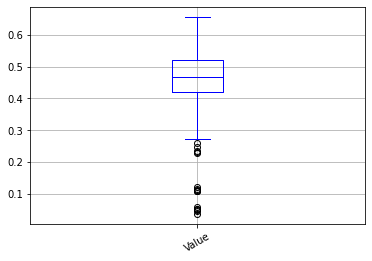

In [74]:
radiomics_features_flatness.boxplot(column="Value", grid='false', color='blue',fontsize=10, rot=30 )

In [75]:
%%bigquery radiomics_features_all --project=bwh-midrc-rapid-res-1655321320

# SELECT * FROM `bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements` 
SELECT * FROM `bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif` 

#where (Quantity.CodeMeaning = "Flatness" AND 
#      Quantity.CodeMeaning = "SurfaceArea")


Query is running:   0%|          |

Downloading:   0%|          |

In [76]:
radiomics_features_all.columns

Index(['PatientID', 'SOPInstanceUID', 'SeriesDescription',
       'measurementGroup_number', 'segmentationInstanceUID',
       'segmentationSegmentNumber', 'sourceSegmentedSeriesUID',
       'trackingIdentifier', 'Quantity', 'Value', 'Units', 'finding',
       'findingSite', 'viewer_url'],
      dtype='object')

In [77]:
radiomics_features_all

,PatientID,SOPInstanceUID,SeriesDescription,measurementGroup_number,segmentationInstanceUID,segmentationSegmentNumber,sourceSegmentedSeriesUID,trackingIdentifier,Quantity,Value,Units,finding,findingSite,viewer_url
0,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 2', 'CodeValue': ...",0.166000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
1,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Sphericity', 'CodeValue': 'QC...",0.550000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
2,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Spherical Disproportion', 'Co...",1.818000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
3,10000364-1265772,1.2.276.0.7230010.3.1.4.481037312.137108.16742...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.55288.167416...,[1],2.16.840.1.114274.1818.46118491946398479151628...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 1', 'CodeValue': ...",0.022000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
4,419639-009729,1.2.276.0.7230010.3.1.4.481037312.8709.1674257...,lungmask_Measurements,0,1.2.276.0.7230010.3.1.4.481037312.7172.1674164...,[1],1.2.826.0.1.3680043.10.474.419639.105799060738...,Measurements group 1 - Right,"{'CodeMeaning': 'Compactness 1', 'CodeValue': ...",0.018000000,"{'CodeMeaning': 'no units', 'CodeValue': '1', ...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,10000364-6553682,1.2.276.0.7230010.3.1.4.481037312.53280.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.281134.16741...,[2],2.16.840.1.114274.1818.57397787504841581752943...,Measurements group 2 - Left,"{'CodeMeaning': 'Surface Area of Mesh', 'CodeV...",89594.747000000,"{'CodeMeaning': 'square millimeter', 'CodeValu...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
10496,10000364-5793210,1.2.276.0.7230010.3.1.4.481037312.56910.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.282551.16741...,[2],2.16.840.1.114274.1818.57457975148752254386654...,Measurements group 2 - Left,"{'CodeMeaning': 'Surface Area of Mesh', 'CodeV...",88364.939000000,"{'CodeMeaning': 'square millimeter', 'CodeValu...","{'CodeMeaning': 'Organ', 'CodeValue': '1133430...","{'CodeMeaning': 'Lung', 'CodeValue': '39607008...",https://idc-tester-1.web.app/projects/bwh-midr...
10497,10000364-1714989,1.2.276.0.7230010.3.1.4.481037312.58771.167435...,lungmask_Measurements,1,1.2.276.0.7230010.3.1.4.481037312.283269.16741...,[2],2.16.840.1.114274.1818.57558246195587971841446...,Measurements group 2 - Left,"{'CodeMeaning

In [ ]:
# test

In [78]:
%%bigquery radiomics_features_test --project=bwh-midrc-rapid-res-1655321320

WITH
  flatness_series AS (
  SELECT
    *
  FROM
    # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
    bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif
  WHERE
    Quantity.CodeMeaning = "Flatness" 
    #Quantity.CodeMeaning = "VoxelVolume"
    )

SELECT
  StudyInstanceUID,
  Value,
  CONCAT("https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/", StudyInstanceUID) as viewer_url
FROM
  # bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr AS dicom_all
   bwh-midrc-rapid-res-1655321320.midrc_dicom_us.midrc_with_seg_sr_dk AS dicom_all
JOIN
  flatness_series
ON
  flatness_series.SOPInstanceUID = dicom_all.SOPInstanceUID
ORDER BY
  Value DESC
  # https://idc-tester-1.web.app/projects/bwh-midrc-rapid-res-1655321320/locations/us-central1/datasets/afedorov-hc-dataset/dicomStores/dicom/study/2.16.840.1.114274.1818.47388429601053462484705357181174281372

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
%%bigquery test --project=bwh-midrc-rapid-res-1655321320
# SELECT * FROM bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements
SELECT * FROM bwh-midrc-rapid-res-1655321320.midrc_dicom_us.quantitative_measurements_features_dk_with_ohif


Query is running:   0%|          |

Downloading:   0%|          |

In [80]:
test.Quantity[0]

{'CodeMeaning': 'Compactness 2',
 'CodeValue': 'BQWJ',
 'CodingSchemeDesignator': 'IBSI'}

In [81]:
tq_list = test['Quantity'].tolist()

In [82]:
tq_meaning = [t['CodeMeaning'] for t in tq_list]

In [83]:
test['CodeMeaning']  = tq_meaning
test['CodeMeaning']= test['CodeMeaning'].astype(str)

In [84]:
test.columns

Index(['PatientID', 'SOPInstanceUID', 'SeriesDescription',
       'measurementGroup_number', 'segmentationInstanceUID',
       'segmentationSegmentNumber', 'sourceSegmentedSeriesUID',
       'trackingIdentifier', 'Quantity', 'Value', 'Units', 'finding',
       'findingSite', 'viewer_url', 'CodeMeaning'],
      dtype='object')

In [85]:
len(set(test.sourceSegmentedSeriesUID))

375

In [86]:
len(set(test.CodeMeaning))

14

In [87]:
set(test.Value)

{Decimal('0.500000000'),
 Decimal('0.125000000'),
 Decimal('0.375000000'),
 Decimal('0.875000000'),
 Decimal('0.750000000'),
 Decimal('267.772000000'),
 Decimal('0.625000000'),
 Decimal('2326528.000000000'),
 Decimal('2.000000000'),
 Decimal('2499810.042000000'),
 Decimal('426012.000000000'),
 Decimal('1156352.917000000'),
 Decimal('299.147000000'),
 Decimal('1465176.333000000'),
 Decimal('1268582.708000000'),
 Decimal('70.625000000'),
 Decimal('2818120.000000000'),
 Decimal('140851.814000000'),
 Decimal('93.000000000'),
 Decimal('94.375000000'),
 Decimal('2022276.083000000'),
 Decimal('102.000000000'),
 Decimal('2162797.000000000'),
 Decimal('111.750000000'),
 Decimal('114.375000000'),
 Decimal('117.000000000'),
 Decimal('1540222.500000000'),
 Decimal('852096.000000000'),
 Decimal('135.750000000'),
 Decimal('137.750000000'),
 Decimal('109717.821000000'),
 Decimal('148.000000000'),
 Decimal('148.375000000'),
 Decimal('1573013.000000000'),
 Decimal('153.750000000'),
 Decimal('156.250000

In [89]:
df_total = pd.DataFrame()
for cm in set(test.CodeMeaning):
  print(cm)
  df = test[test.CodeMeaning == cm]
  df = df.groupby('sourceSegmentedSeriesUID').first()
  #print(df.Value)
  df_cm = pd.DataFrame(columns = ['sourceSegmentedSeriesUID','Value','CodeMeaning'])
  #print(df_cm)
  df_cm['sourceSegmentedSeriesUID'] = list(df.index.values)
  df_cm['Value'] = df.Value.tolist()
  df_cm['Value'] = df_cm['Value'].astype(float)
  df_cm['CodeMeaning'] = cm
  df_total = df_total.append(df_cm)
  #break

Major Axis in 3D Length
Compactness 1
Surface to Volume Ratio
Flatness
Compactness 2
Maximum 3D Diameter of a Mesh
Volume of Mesh
Minor Axis in 3D Length
Volume from Voxel Summation
Surface Area of Mesh
Sphericity
Spherical Disproportion
Least Axis in 3D Length
Elongation


In [90]:
df_total

,sourceSegmentedSeriesUID,Value,CodeMeaning
0,1.2.826.0.1.3680043.10.474.419639.105799060738...,191.605,Major Axis in 3D Length
1,1.2.826.0.1.3680043.10.474.419639.106364025147...,212.918,Major Axis in 3D Length
2,1.2.826.0.1.3680043.10.474.419639.149051607502...,256.166,Major Axis in 3D Length
3,1.2.826.0.1.3680043.10.474.419639.189346812051...,239.929,Major Axis in 3D Length
4,1.2.826.0.1.3680043.10.474.419639.198735019931...,129.972,Major Axis in 3D Length
...,...,...,...
370,2.16.840.1.114274.1818.57428402673806292631213...,0.869,Elongation
371,2.16.840.1.114274.1818.57457975148752254386654...,0.810,Elongation
372,2.16.840.1.114274.1818.57558246195587971841446...,0.933,Elongation
373,2.16.840.1.114274.1818.57625389167518869141350...,0.982,Elongation


In [91]:
374*14

5236

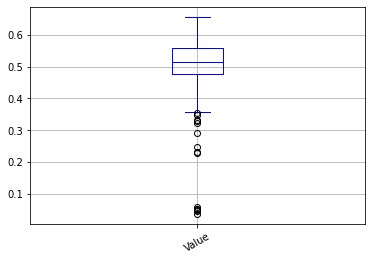

In [92]:
df_total[df_total.CodeMeaning=='Flatness'].boxplot(column="Value", grid='false', color='blue',fontsize=10, rot=30 )

In [93]:
df_total

,sourceSegmentedSeriesUID,Value,CodeMeaning
0,1.2.826.0.1.3680043.10.474.419639.105799060738...,191.605,Major Axis in 3D Length
1,1.2.826.0.1.3680043.10.474.419639.106364025147...,212.918,Major Axis in 3D Length
2,1.2.826.0.1.3680043.10.474.419639.149051607502...,256.166,Major Axis in 3D Length
3,1.2.826.0.1.3680043.10.474.419639.189346812051...,239.929,Major Axis in 3D Length
4,1.2.826.0.1.3680043.10.474.419639.198735019931...,129.972,Major Axis in 3D Length
...,...,...,...
370,2.16.840.1.114274.1818.57428402673806292631213...,0.869,Elongation
371,2.16.840.1.114274.1818.57457975148752254386654...,0.810,Elongation
372,2.16.840.1.114274.1818.57558246195587971841446...,0.933,Elongation
373,2.16.840.1.114274.1818.57625389167518869141350...,0.982,Elongation


In [94]:
df_total.columns

Index(['sourceSegmentedSeriesUID', 'Value', 'CodeMeaning'], dtype='object')

In [95]:
col_list = ['sourceSegmentedSeriesUID'] + list(set(df_total.CodeMeaning))
df_total_by_feature = pd.DataFrame(columns=col_list)
df_total_by_feature

,sourceSegmentedSeriesUID,Least Axis in 3D Length,Major Axis in 3D Length,Compactness 1,Surface to Volume Ratio,Compactness 2,Maximum 3D Diameter of a Mesh,Volume of Mesh,Minor Axis in 3D Length,Volume from Voxel Summation,Surface Area of Mesh,Sphericity,Spherical Disproportion,Flatness,Elongation


In [96]:
for cm in set(df_total.CodeMeaning):
  df = df_total[df_total.CodeMeaning == cm]
  df_total_by_feature.sourceSegmentedSeriesUID = list(df.index.values)
  df_total_by_feature[cm] = df.Value
  df_total_by_feature[cm] = df_total_by_feature[cm].astype(float)

In [97]:
df_total_by_feature

,sourceSegmentedSeriesUID,Least Axis in 3D Length,Major Axis in 3D Length,Compactness 1,Surface to Volume Ratio,Compactness 2,Maximum 3D Diameter of a Mesh,Volume of Mesh,Minor Axis in 3D Length,Volume from Voxel Summation,Surface Area of Mesh,Sphericity,Spherical Disproportion,Flatness,Elongation
0,0,47.540,191.605,0.018,0.129,0.121,184.968,429726.042,96.279,429913.0,55626.157,0.495,2.020,0.248,0.502
1,1,93.452,212.918,0.025,0.067,0.215,261.851,1749570.292,145.162,1749793.0,117152.431,0.599,1.668,0.439,0.682
2,2,124.805,256.166,0.023,0.053,0.196,311.657,3826057.542,199.769,3826321.0,203823.060,0.580,1.723,0.487,0.780
3,3,77.816,239.929,0.019,0.093,0.126,240.568,1132342.875,125.691,1132623.0,104843.058,0.501,1.996,0.324,0.524
4,4,73.442,129.972,0.023,0.115,0.181,140.922,407151.458,80.874,407310.0,46928.178,0.566,1.766,0.565,0.622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,370,94.430,173.518,0.021,0.081,0.158,220.266,1342063.125,150.716,1342328.0,108724.588,0.541,1.848,0.544,0.869
371,371,104.286,174.365,0.021,0.083,0.150,200.900,1318294.750,141.149,1318584.0,109449.543,0.531,1.882,0.598,0.810
372,372,97.331,169.248,0.019,0.088,0.131,214.276,1264009.667,157.865,1264244.0,111313.326,0.508,1.969,0.575,0.933
373,373,104.562,172.286,0.020,0.080,0.143,229.212,1528397.250,169.114,1528571.0,122588.038,0.523,1.910,0.607,0.982


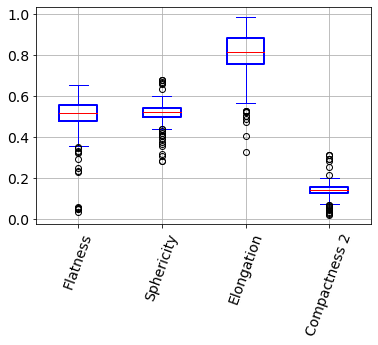

In [98]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=1, color='red')

df_total_by_feature.boxplot( column = ['Flatness','Sphericity','Elongation', 'Compactness 2'],  color='blue',fontsize=14, rot=70, boxprops=boxprops, medianprops=medianprops)

In [ ]:
fig_fn = '\content\boxplot1.png'
plt.savefig(fig_fn)

<Figure size 432x288 with 0 Axes>

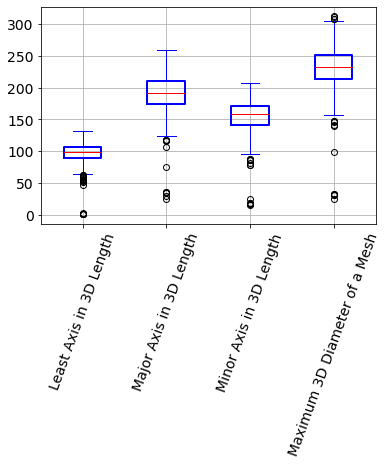

In [99]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=1, color='red')

df_total_by_feature.boxplot( column = ['Least Axis in 3D Length','Major Axis in 3D Length','Minor Axis in 3D Length','Maximum 3D Diameter of a Mesh'], grid='false', color='blue',fontsize=14, rot=70,boxprops=boxprops, medianprops=medianprops )

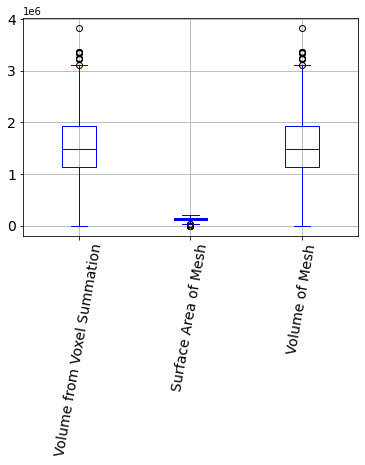

In [100]:
df_total_by_feature.boxplot( column = ['Volume from Voxel Summation','Surface Area of Mesh','Volume of Mesh'], grid='false', color='blue',fontsize=14, rot=80 )
